### Import all necessary libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('Telco-Customer-Churn.csv')
data.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


### EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        7
Churn               0
dtype: int64

In [5]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7036.000000
mean,0.162147,32.371149,64.761692,2282.002374
std,0.368612,24.559481,30.090047,2266.780423
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,400.225000
50%,0.000000,29.000000,70.350000,1396.575000
75%,0.000000,55.000000,89.850000,3792.325000
max,1.000000,72.000000,118.750000,8684.800000


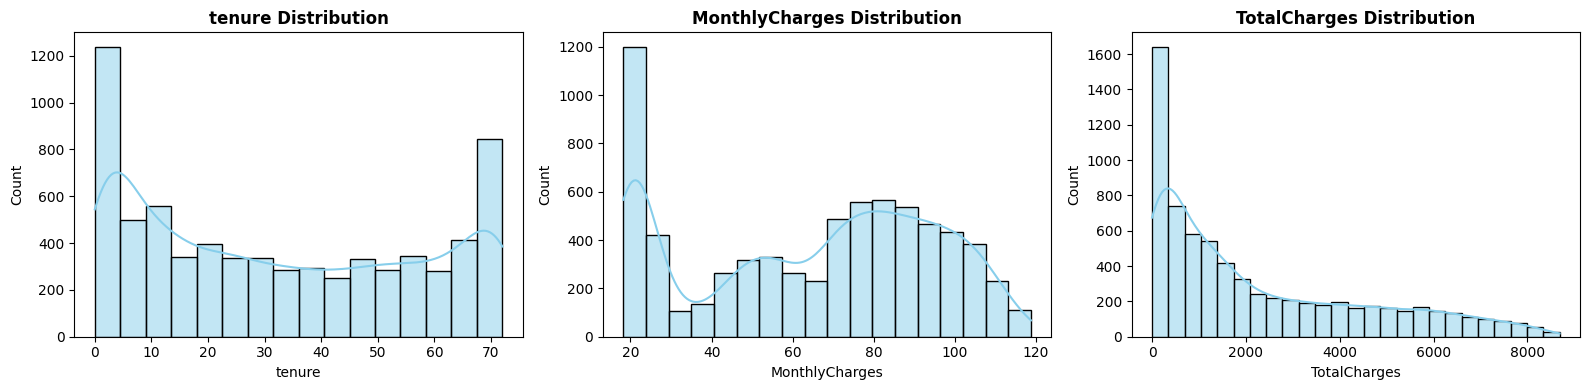

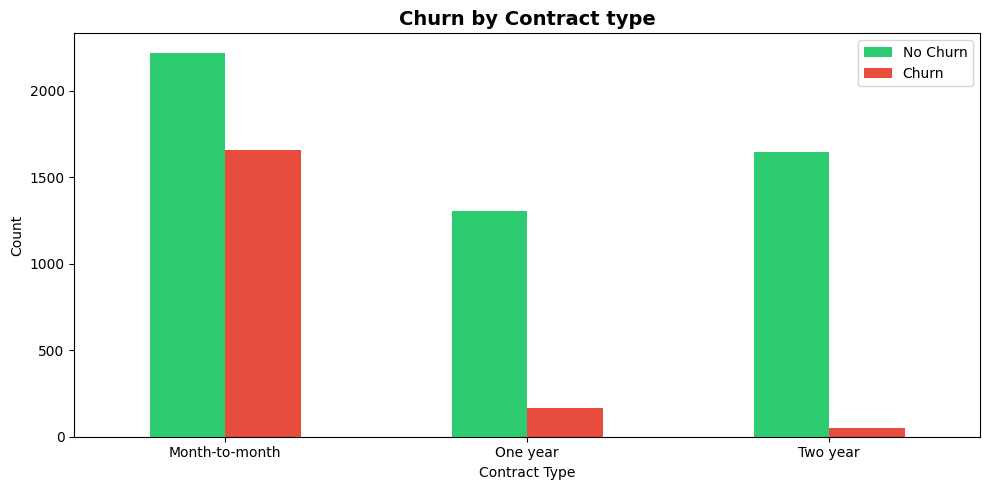

In [6]:
fig , axes = plt.subplots(1, 3, figsize=(16,4))

for idx, col in enumerate(["tenure", "MonthlyCharges","TotalCharges"]):
    sns.histplot(data[col], kde=True, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

#churn by contract

fig, ax = plt.subplots(1,1, figsize=(10, 5))
contract_churn = data.groupby(['Contract', 'Churn']).size().unstack(fill_value=0)
contract_churn.plot(kind='bar', stacked=False, ax=ax, color=['#2ecc71', '#e74c3c'])
ax.set_title('Churn by Contract type', fontsize=14, fontweight='bold')
ax.set_xlabel('Contract Type')
ax.set_ylabel('Count')
ax.legend(['No Churn', 'Churn'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

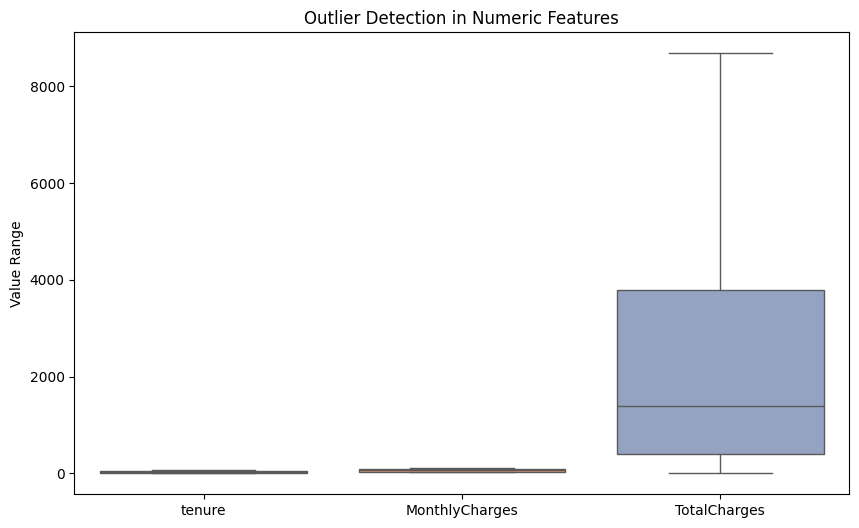

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(10, 6))
sns.boxplot(data=data[numeric_cols], palette="Set2")

plt.title('Outlier Detection in Numeric Features')
plt.ylabel('Value Range')
plt.show()

### Summary of EDA
- No need of this CustomerID column
- Need to remove duplicates
- Change TotalCharges column dtype and fill null empty string
- No outlier present
- Encode object columns and we identify our target column is churn so it also encode amd will split

### Feature Engineering

In [8]:
data = data.drop('customerID',axis=1)

In [9]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [10]:
null_rows_df = data[data.isnull().any(axis=1)]

print(null_rows_df)

      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
1340  No phone service             DSL                  Yes   
3331                No              No  No internet service   
3826               Yes              No  No internet service   
4380                No              No  No internet service   
5218                No              No  No internet service   
6670               Yes             DSL               

In [11]:
data['TotalCharges'] = data['TotalCharges'].fillna(0)

In [12]:
data['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [13]:
data['Churn'] = data['Churn'].replace('Yes',1)
data['Churn'] = data['Churn'].replace('No',0)

In [14]:
counts = data['Churn'].value_counts()
counts

Churn
0    5174
1    1869
Name: count, dtype: int64

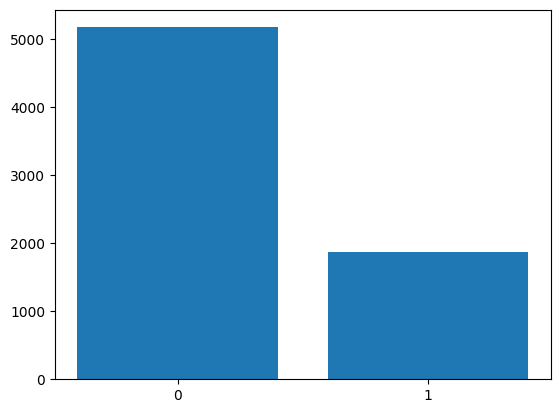

In [15]:
plt.bar(counts.index, counts.values)
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.show()

In [16]:
col = []
for column in data.columns:
    if data[column].dtype=='object':
        col.append(column)

In [17]:
col

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [18]:
for i in col:
    print(i)
    print(data[i].unique())
    print('*'*50)

gender
['Female' 'Male']
**************************************************
Partner
['Yes' 'No']
**************************************************
Dependents
['No' 'Yes']
**************************************************
PhoneService
['No' 'Yes']
**************************************************
MultipleLines
['No phone service' 'No' 'Yes']
**************************************************
InternetService
['DSL' 'Fiber optic' 'No']
**************************************************
OnlineSecurity
['No' 'Yes' 'No internet service']
**************************************************
OnlineBackup
['Yes' 'No' 'No internet service']
**************************************************
DeviceProtection
['No' 'Yes' 'No internet service']
**************************************************
TechSupport
['No' 'Yes' 'No internet service']
**************************************************
StreamingTV
['No' 'Yes' 'No internet service']
**************************************************
StreamingM

In [19]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for i in col:
    data[i] = encoder.fit_transform(data[i])

In [20]:
data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1990.50,0
7039,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,7362.90,0
7040,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,306.60,1


In [21]:
data.duplicated().sum()

22

In [22]:
data.drop_duplicates()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1990.50,0
7039,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,7362.90,0
7040,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,306.60,1


In [23]:
data.shape

(7043, 20)

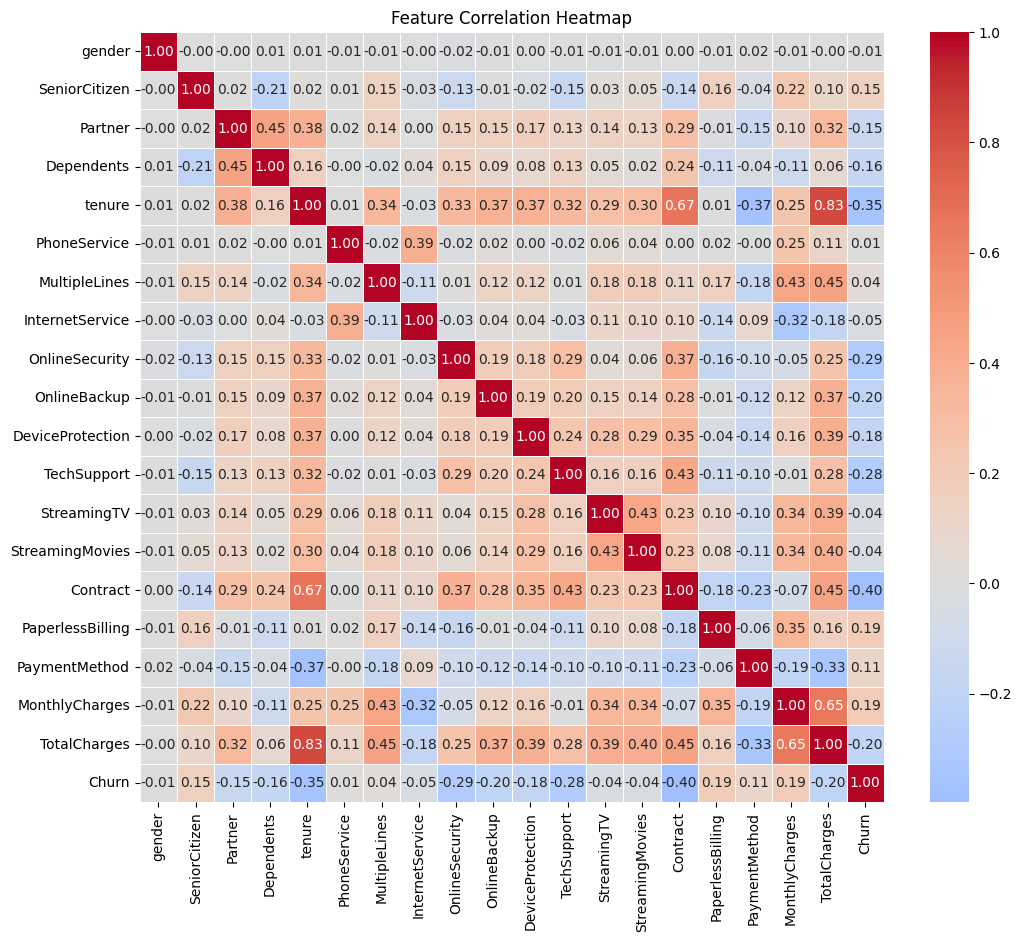

In [24]:
corr_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,         
    annot=True,          
    fmt=".2f",         
    cmap='coolwarm',     
    center=0,            
    linewidths=0.5
)

plt.title('Feature Correlation Heatmap')
plt.show()

### Summary 
- No need of CustomerID so drop it.
- TotalCharges convert to numeric and fill null(empty string) with 0
- Remove Duplicates
- Encoded all object and target(churn) columns.

### Split Train and Test Data

In [25]:
X = data.drop('Churn',axis=1)
y = data['Churn']

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [27]:
X_train.shape,y_train.shape

((5634, 19), (5634,))

In [28]:
print(y_train.value_counts())

Churn
0    4138
1    1496
Name: count, dtype: int64


### Imbalanced Dataset Handling

In [29]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

### Standard Scaling

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model Training and Evaluation

In [31]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "knn" : KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    pr = precision_score(y_test,y_pred)
    re = recall_score(y_test,y_pred)
    
    results[name] = accuracy
    print(f"  {name} Accuracy: {accuracy:.4f}")
    print(f"  {name} F1 Score: {f1:.4f}")
    print(f"  {name} Precision: {pr:.4f}")
    print(f"  {name} Recall: {re:.4f}\n")

Training Logistic Regression...
  Logistic Regression Accuracy: 0.6899
  Logistic Regression F1 Score: 0.6074
  Logistic Regression Precision: 0.4568
  Logistic Regression Recall: 0.9062

Training Random Forest...
  Random Forest Accuracy: 0.7786
  Random Forest F1 Score: 0.6031
  Random Forest Precision: 0.5738
  Random Forest Recall: 0.6354

Training Decision Tree...
  Decision Tree Accuracy: 0.7055
  Decision Tree F1 Score: 0.5311
  Decision Tree Precision: 0.4590
  Decision Tree Recall: 0.6300

Training SVC...
  SVC Accuracy: 0.7374
  SVC F1 Score: 0.6039
  SVC Precision: 0.5027
  SVC Recall: 0.7560

Training XGBoost...
  XGBoost Accuracy: 0.3052
  XGBoost F1 Score: 0.4325
  XGBoost Precision: 0.2759
  XGBoost Recall: 1.0000

Training knn...
  knn Accuracy: 0.6835
  knn F1 Score: 0.5522
  knn Precision: 0.4414
  knn Recall: 0.7373



In [32]:
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_results[name] = scores.mean()
    print(f"{name} Accuracy: {scores.mean():.4f}")

Logistic Regression Accuracy: 0.7927
Random Forest Accuracy: 0.8404
Decision Tree Accuracy: 0.7803
SVC Accuracy: 0.8101
XGBoost Accuracy: 0.8340
knn Accuracy: 0.7852


In [33]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('svc', SVC(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("xgb", XGBClassifier(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svc', SVC(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weigh...ne, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))])

In [34]:
y_pred = voting_clf.predict(X_test)
    
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)
pr = precision_score(y_test,y_pred)
re = recall_score(y_test,y_pred)
    
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {pr:.4f}")
print(f"Recall: {re:.4f}")

Accuracy: 0.7346
F1 Score: 0.6071
Precision: 0.4991
Recall: 0.7748


#### Random Forest is good perform so we consider it as our final model

In [35]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Final Accuracy: 0.7786

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1036
           1       0.57      0.64      0.60       373

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.79      0.78      0.78      1409



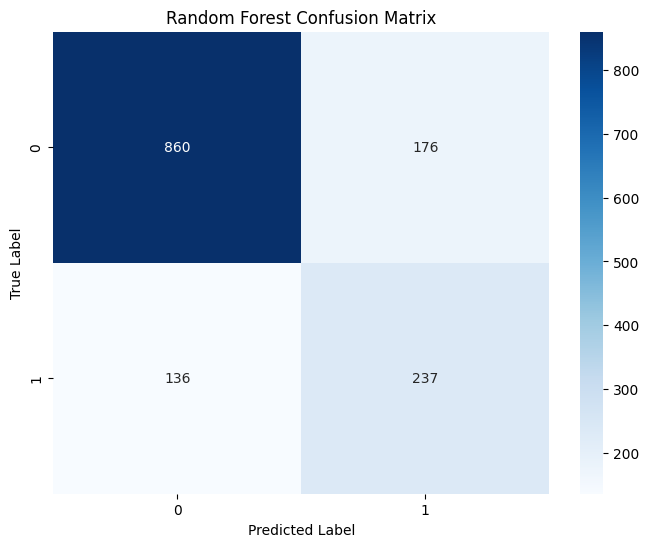

In [36]:
y_pred = rfc.predict(X_test)

print(f"Final Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Final Model

In [37]:
import joblib
with open("customer_churn_model.pkl","wb") as f:
    joblib.dump(rfc,f)